In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from resources.conv_learner import * # important because our ResNet name needs to override theirs
from resources.plots import *
from common import Statistics, dataset_source
from models import ResNet

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200
SEED = 5
# set the seeds for experimentation
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
stats_name = "yeast_v5_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


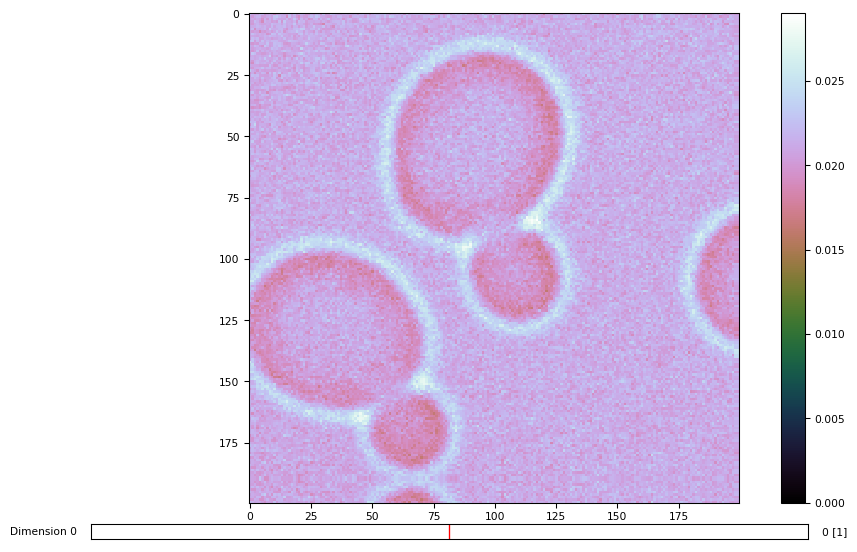

In [10]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

## ResNet_with_Batchnorm

In [11]:
sorted(os.listdir(PATH+'/models'))

['Objective_A_Resnet_per_class_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_2.h5',
 'Objective_C_Resnet_per_class_3.h5',
 'Objective_C_Resnet_per_class_balanced_1.h5',
 'Objective_C_Resnet_per_dataset_2.h5',
 'Objective_C_Resnet_per_dataset_3.h5',
 'ResNet5_default_07-24_23-18.h5',
 'ResNet5_v5_batch_adj_07-24_16-46.h5',
 'ResNet5_v5_batch_adj_07-24_18-32.h5',
 'ResNet5_v5_batch_adj_07-24_18-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-11.h5',
 'ResNet5_v5_batch_adj_07-24_19-32.h5',
 'ResNet5_v5_batch_adj_07-24_19-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-59.h5',
 'ResNet5_v5_batch_adj_07-24_20-27.h5']

In [15]:
model = ResNet([10, 20, 40, 80, 160], 6, obj_name="embeddings", tb_log=True)
learn = ConvLearner.from_model_data(model, data)

In [16]:
learn.load('ResNet5_default_07-24_23-18')

In [18]:
learn.warm_up(1e-3)

  0%|          | 0/21 [00:00<?, ?it/s][0]: 34.29%
[1]: 54.29%
[2]:  0.0%
[3]: 45.71%
[4]: 61.43%
[5]: 82.86%
EPOCH 0 ---------------                                    
epoch      trn_loss   val_loss   accuracy   
    0      0.229671   0.419405   0.901587  
f1 weighted average score: [0.9012]


[array([0.41941]), 0.9015873012088594]

In [59]:
preds = learn.predict()
preds = torch.from_numpy(preds)

torch.Size([64, 160, 13, 13])
torch.Size([64, 6])
torch.Size([64, 160, 13, 13])
torch.Size([64, 6])
torch.Size([64, 160, 13, 13])
torch.Size([64, 6])
torch.Size([64, 160, 13, 13])
torch.Size([64, 6])
torch.Size([59, 160, 13, 13])
torch.Size([59, 6])


In [33]:
learn.model.writer.add_embedding()

(315, 6)

In [39]:
xs = np.array([x.cpu().numpy() for x, y in data.val_dl])
xs = np.concatenate(xs)
xs = torch.from_numpy(xs)

In [40]:
ys = np.array([y.cpu().numpy() for x, y in data.val_dl])
ys = np.concatenate(ys)
ys = torch.from_numpy(ys)

In [48]:
zeros = torch.zeros(315,1,200,200)

In [56]:
rgb_xs = torch.cat((zeros, txs), 1)

In [61]:
learn.model.writer.add_embedding(preds, ys, rgb_xs, 90, tag='90 percent accuracy')

In [58]:
type(smt)

numpy.ndarray